In [1]:
# !pip install opencv-python scikit-learn scikit-image matplotlib spectral keras_tuner vis
# !pip install tensorflow numpy pandas
# !pip install spectral

In [2]:
import tensorflow as tf

2023-07-21 16:30:25.347121: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from tensorflow import keras as keras
from keras import layers as layers

In [4]:
import os, timeit
from skimage.filters import threshold_otsu
import numpy as np
from math import inf as inf

In [5]:
import pandas as pd

In [6]:
from spectral.io import envi as envi
from spectral import imshow

In [7]:
from sklearn.decomposition import IncrementalPCA

In [8]:
import sys

In [9]:
from tensorflow.keras.utils import set_random_seed
set_random_seed(42)

In [10]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [11]:
from sys import platform
DATA_DIRECTORY = ""
SLASH = ""
if platform == "linux" or platform == "linux2":
    DATA_DIRECTORY = "/home/tyagi/Desktop/wheat/data/BULK/"
    SLASH = "/"
elif platform == "win32":
    DATA_DIRECTORY = "D:\mvl\wheat\data\BULK\\"
    SLASH="\\"

In [12]:
#Constants
BAND_NUMBER = 60
FILLED_AREA_RATIO = 0.9
TOTAL_IMAGE_COUNT = 2400
IMAGE_COUNT = int(TOTAL_IMAGE_COUNT/4)
NUM_VARIETIES = 4

IMAGE_WIDTH = 30
IMAGE_HEIGHT = 30

In [13]:
ACTIVATION_TYPE =  "relu"
BATCH_SIZE = 2*NUM_VARIETIES

LEARNING_RATE_BASE = 0.0001

In [14]:
from enum import Enum

class filter_method(Enum):
    none = 0
    snv = 1
    msc = 2
    savgol = 3
    
FILTER = filter_method(1).name

# to be set if filter chosen is savgol
WINDOW = 7
ORDER = 2
DERIVATIVE = "none"

In [15]:
from enum import Enum
 
class feature_extraction_method(Enum):
    none = 0
    pca_loading = 1
    lda = 2
    ipca = 3

FEATURE_EXTRACTION = feature_extraction_method(0).name

NUM_OF_BANDS = 3
if FEATURE_EXTRACTION == "pca_loading" or FEATURE_EXTRACTION == "ipca":
    NUM_OF_BANDS = 8
elif FEATURE_EXTRACTION == "lda":
    NUM_OF_BANDS = 3
    assert NUM_OF_BANDS <= min(NUM_VARIETIES-1,168),"NUM_OF_BANDS is greater."


REMOVE_NOISY_BANDS = True
FIRST_BAND = 15
LAST_BAND = 161

In [16]:
def start_timer():
    print("Testing started")
    return timeit.default_timer()

def end_timer():
    return timeit.default_timer()

def show_time(tic,toc): 
    test_time = toc - tic
    print('Testing time (s) = ' + str(test_time) + '\n')

In [17]:
# List for All varieties
VARIETIES = []
VARIETIES_CODE = {}

for name in os.listdir(DATA_DIRECTORY):
    if (name.endswith(".hdr") or name.endswith(".bil")):
        continue
    VARIETIES_CODE[name] = len(VARIETIES)
    VARIETIES.append(name)
    if len(VARIETIES)==NUM_VARIETIES:
        break

In [18]:
def dataset_file_name(variety):
    name = "./dataset/V"+str(variety).zfill(3)+"_IC_"+str(TOTAL_IMAGE_COUNT).zfill(5)+"_FilledArea_"+str(FILLED_AREA_RATIO)+"_NumOfBands_"+str(NUM_OF_BANDS)+"_FB_"+str(FIRST_BAND)+"_LB_"+str(LAST_BAND)+"_BandNo_"+str(BAND_NUMBER)+"_ImageHeight_"+str(IMAGE_HEIGHT)+"_ImageWidth_"+str(IMAGE_WIDTH)+"_FILTER_"+str(FILTER)+"_FeatureExtraction_"+str(FEATURE_EXTRACTION)
    if REMOVE_NOISY_BANDS:
        name+="_REMOVE_NOISY_BANDS_"+str(REMOVE_NOISY_BANDS)
    if FILTER == "savgol":
        name+="_WINDOW_"+str(WINDOW)+"_ORDER_"+str(ORDER)
    return name

In [19]:
train_dataset = []
train_dataset_label = []
test_dataset=[]
test_dataset_label = []

for idx, v in enumerate(VARIETIES):
    print("idx: ",idx)
    if idx >= NUM_VARIETIES:
        break
    train_dataset= train_dataset + np.load(dataset_file_name(v)+"_train_dataset.npy").tolist()
    train_dataset_label = train_dataset_label + np.load(dataset_file_name(v)+"_train_dataset_label.npy").tolist()
    test_dataset = test_dataset + np.load(dataset_file_name(v)+"_test_dataset.npy").tolist()
    test_dataset_label = test_dataset_label + np.load(dataset_file_name(v)+"_test_dataset_label.npy").tolist()
    
train_dataset = np.array(train_dataset)
train_dataset_label = np.array(train_dataset_label)
test_dataset = np.array(test_dataset)
test_dataset_label = np.array(test_dataset_label)

idx:  0
idx:  1
idx:  2
idx:  3


In [20]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses, Model
from keras.layers import Input, Conv2D, MaxPool2D, MaxPooling2D, Activation, Flatten, Dense, AveragePooling2D, GlobalAveragePooling2D
from keras.layers.core import Dropout
from keras.optimizers import Adam

In [21]:
def normalizeDataWholeSeed(data,normalization_type='max'):
    
    if normalization_type == 'max':
        for idx in range(data.shape[0]):
            data[idx,:,:,:] = data[idx,:,:,:]/np.max(abs(data[idx,:,:,:]))
            
    elif normalization_type == 'l2norm':
        from numpy import linalg as LA
        for idx in range(data.shape[0]):
            data[idx,:,:,:] = data[idx,:,:,:]/LA.norm(data[idx,:,:,:])       
        
    return data

In [22]:
def inception(x,filters_1x1,filters_3x3_reduce,filters_3x3,filters_5x5_reduce,filters_5x5,filters_pool,activation_type='relu'):
    path1 = Conv2D(filters_1x1,        (1, 1), padding='same', activation=activation_type)(x)
    
    path2 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation=activation_type)(x)
    path2 = Conv2D(filters_3x3,        (1, 1), padding='same', activation=activation_type)(path2)
    
    path3 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation=activation_type)(x)
    path3 = Conv2D(filters_5x5,        (1, 1), padding='same', activation=activation_type)(path3)
    
    path4 = MaxPool2D((3, 3),  strides=(1, 1), padding='same')(x)
    path4 = Conv2D(filters_pool,       (1, 1), padding='same', activation=activation_type)(path4)
    
    return tf.concat([path1, path2, path3, path4], axis=3)

In [23]:
def auxiliary_classifier(x,num_classes,activation_type='relu'):
    aux = AveragePooling2D((5, 5), strides=3)(x)
    aux = Conv2D(128, 1, padding='same', activation=activation_type)(aux)
    aux = Flatten()(aux)
    aux = Dense(1024, activation=activation_type)(aux)
    aux = Dropout(0.7)(aux)
    aux = Dense(num_classes, activation='softmax')(aux)
    return aux

In [24]:
def GoogleNetModel(data_num_rows, data_num_cols, num_input_chans=1, num_classes=NUM_VARIETIES, activation_type='relu', dropout_rate=0.0):

    inp = Input(shape=(data_num_rows, data_num_cols, num_input_chans))
    input_tensor = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=train_dataset.shape[1:])(inp)
    x = Conv2D(64,  7, strides=2, padding='same', activation=activation_type)(input_tensor)
    x = MaxPooling2D(3, strides=2)(x)
    x = Conv2D(64,  1, strides=1, padding='same', activation=activation_type)(x)
    x = Conv2D(192, 3, strides=1, padding='same', activation=activation_type)(x)
    x = MaxPooling2D(3, strides=2)(x)
    x = inception(x, filters_1x1=64 , filters_3x3_reduce=96 , filters_3x3=128, filters_5x5_reduce=16, filters_5x5=32, filters_pool=32)
    x = inception(x, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=192, filters_5x5_reduce=32, filters_5x5=96, filters_pool=64)
    x = MaxPooling2D(3, strides=2)(x)
    x = inception(x, filters_1x1=192, filters_3x3_reduce=96 , filters_3x3=208, filters_5x5_reduce=16, filters_5x5=48, filters_pool=64)
    
    aux1 = auxiliary_classifier(x,num_classes)
    
    x = inception(x, filters_1x1=160, filters_3x3_reduce=112, filters_3x3=224, filters_5x5_reduce=24, filters_5x5=64, filters_pool=64)
    x = inception(x, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=256, filters_5x5_reduce=24, filters_5x5=64, filters_pool=64)
    x = inception(x, filters_1x1=112, filters_3x3_reduce=144, filters_3x3=288, filters_5x5_reduce=32, filters_5x5=64, filters_pool=64)
    
    aux2 = auxiliary_classifier(x,num_classes)
    
    x = inception(x, filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool=128)
    x = MaxPooling2D(3, strides=2)(x)
    x = inception(x, filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool=128)
    x = inception(x, filters_1x1=384, filters_3x3_reduce=192, filters_3x3=384, filters_5x5_reduce=48, filters_5x5=128, filters_pool=128)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    out = Dense(num_classes, activation='softmax')(x)
    
    return Model(inputs = inp, outputs = [out, aux1, aux2])

In [25]:
def getGoogleNetModel():
    learning_rate_base = LEARNING_RATE_BASE
    activation_type = ACTIVATION_TYPE
    wheat_types =  VARIETIES
    num_classes = len(wheat_types)
    dropout_rate = 0.4
    print("--------------Load Data--------------")

    x_training = np.array(train_dataset)
    labels_training = np.array(train_dataset_label)
    
    # Normalize the data
    x_training = normalizeDataWholeSeed(x_training)
    
    # Extract some information
    num_train = x_training.shape[0]
    N_spatial = x_training.shape[1:3]
    N_channel = x_training.shape[3]
    
    print("--------------Done--------------")
    
    ############ Create a model ############
    print("--------------Create a model--------------")
    
    # Generate a model
    model = GoogleNetModel(data_num_rows = N_spatial[0], 
                           data_num_cols = N_spatial[1],
                           num_input_chans = N_channel, 
                           num_classes = num_classes,
                           activation_type = activation_type,
                           dropout_rate = dropout_rate)

    # Compile the model
    adam_opt = Adam(learning_rate=LEARNING_RATE_BASE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.01)
    model.compile(optimizer=adam_opt, loss=[losses.sparse_categorical_crossentropy,losses.sparse_categorical_crossentropy,losses.sparse_categorical_crossentropy],loss_weights=[1, 0.3, 0.3],metrics=['accuracy'])
    print("---------Completed---------")
    return model

In [26]:
def plot_graph(df,title,xlabel,ylabel,values=['loss'],legends=[]):
    
    for value in values:
        epoch_count = range(1, len(df.index) + 1)
        plt.plot(epoch_count, df[value].tolist())
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if legends==[]:
        legends = values
    plt.legend(legends, loc='upper left')
    plt.show()

In [27]:
model = getGoogleNetModel()

--------------Load Data--------------
--------------Done--------------
--------------Create a model--------------


2023-07-21 16:34:56.743089: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


---------Completed---------


In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 30, 147  0           []                               
                                )]                                                                
                                                                                                  
 resizing (Resizing)            (None, 224, 224, 14  0           ['input_1[0][0]']                
                                7)                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  461056      ['resizing[0][0]']               
                                )                                                             

In [29]:
x_train = []
y_train = []
x_val = []
y_val = []

for i in range(len(train_dataset)):
    if i%5==0:
        x_val.append(train_dataset[i])
        y_val.append(train_dataset_label[i])
    else:
        x_train.append(train_dataset[i])
        y_train.append(train_dataset_label[i])
        
x_train = np.array(x_train)
y_train = np.array(y_train)
y_train = [y_train,y_train,y_train]

x_val = np.array(x_val)

y_val = np.array(y_val)
y_val = [y_val,y_val,y_val]

In [30]:
train_eva = []
test_eva = []

In [31]:
history_dataframe = pd.DataFrame() 

In [32]:
tic = start_timer()
for x in range(0,30):
    print("\nEpoch: ",x+1)
    history = model.fit(x_train ,y_train ,batch_size=BATCH_SIZE ,epochs=1, verbose=2, validation_data=(x_val, y_val), shuffle=True)
    if history_dataframe.size == 0:
        history_dataframe = pd.DataFrame.from_dict(history.history)
    else:
        history_dataframe = pd.concat([history_dataframe,pd.DataFrame.from_dict(history.history)],axis=0,ignore_index=True)
    print("for testing")
    test_eva.append(model.evaluate(test_dataset,test_dataset_label))
    print("for training")
    train_eva.append(model.evaluate(train_dataset,train_dataset_label))
toc = end_timer()
show_time(tic,toc)

Testing started

Epoch:  1
768/768 - 2054s - loss: 1.9340 - dense_4_loss: 1.1976 - dense_1_loss: 1.2304 - dense_3_loss: 1.2245 - dense_4_accuracy: 0.4170 - dense_1_accuracy: 0.4054 - dense_3_accuracy: 0.4028 - val_loss: 1.8267 - val_dense_4_loss: 1.1336 - val_dense_1_loss: 1.1503 - val_dense_3_loss: 1.1600 - val_dense_4_accuracy: 0.4753 - val_dense_1_accuracy: 0.4564 - val_dense_3_accuracy: 0.4473 - 2054s/epoch - 3s/step
for testing
60/60 [==============================] - 58s 950ms/step - loss: 1.8280 - dense_4_loss: 1.1338 - dense_1_loss: 1.1512 - dense_3_loss: 1.1628 - dense_4_accuracy: 0.4573 - dense_1_accuracy: 0.4563 - dense_3_accuracy: 0.4375
for training
240/240 [==============================] - 226s 943ms/step - loss: 1.8169 - dense_4_loss: 1.1284 - dense_1_loss: 1.1431 - dense_3_loss: 1.1519 - dense_4_accuracy: 0.4724 - dense_1_accuracy: 0.4635 - dense_3_accuracy: 0.4488

Epoch:  2
768/768 - 2039s - loss: 1.7628 - dense_4_loss: 1.0877 - dense_1_loss: 1.1249 - dense_3_loss: 1

In [33]:
history_dataframe

,loss,dense_4_loss,dense_1_loss,dense_3_loss,dense_4_accuracy,dense_1_accuracy,dense_3_accuracy,val_loss,val_dense_4_loss,val_dense_1_loss,val_dense_3_loss,val_dense_4_accuracy,val_dense_1_accuracy,val_dense_3_accuracy
0,1.934029,1.197561,1.230397,1.224497,0.416992,0.405436,0.402832,1.826698,1.133629,1.150272,1.159960,0.475260,0.456380,0.447266
1,1.762791,1.087653,1.124948,1.125514,0.497396,0.470378,0.465332,1.721331,1.069121,1.074065,1.099967,0.517578,0.524740,0.484375
2,1.686661,1.040925,1.074726,1.077724,0.527181,0.505534,0.496094,1.621744,1.002783,1.021639,1.041565,0.572917,0.556641,0.527995
3,1.610867,0.983836,1.046256,1.043845,0.564616,0.527507,0.523112,1.558356,0.958231,0.998042,1.002375,0.592448,0.565755,0.555339
4,1.573644,0.961075,1.023033,1.018863,0.571777,0.546387,0.536621,1.522252,0.932405,0.983884,0.982270,0.600911,0.574219,0.569661
5,1.544762,0.938726,1.018922,1.001199,0.579753,0.545085,0.546061,1.498711,0.915878,0.974383,0.968394,0.610677,0.578125,0.578125
6,1.522237,0.924620,1.005990,0.986069,0.587565,0.548014,0.553385,1.481224,0.903319,0.967743,0.958608,0.613932,0.583333,0.585286
7,1.504592,0.910656,0.997338,0.982452,0.597005,0.555664,0.553060,1.465826,0.892400,0.961611,0.949807,0.617839,0.586589,0.589844
8,1.483513,0.895906,0.991202,0.967489,0.605957,0.554688,0.567057,1.452692,0.882917,0.956763,0.942490,0.626302,0.587891,0.589193
9,1.475333,0.889256,0.989531,0.964056,0.607910,0.554850,0.573079,1.440133,0.873634,0.952595,0.935732,0.626953,0.588542,0.592448


In [34]:
train_eva_df = pd.DataFrame(train_eva,columns=['loss','dense_4_loss','dense_1_loss','dense_3_loss','dense_4_accuracy','dense_1_accuracy','dense_3_accuracy'])
test_eva_df = pd.DataFrame(test_eva,columns=['loss','dense_4_loss','dense_1_loss','dense_3_loss','dense_4_accuracy','dense_1_accuracy','dense_3_accuracy'])

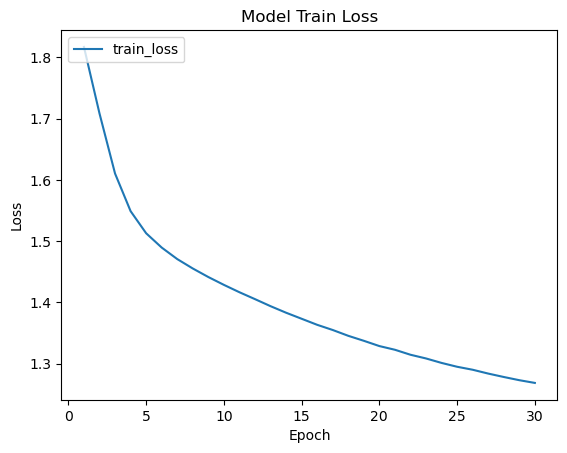

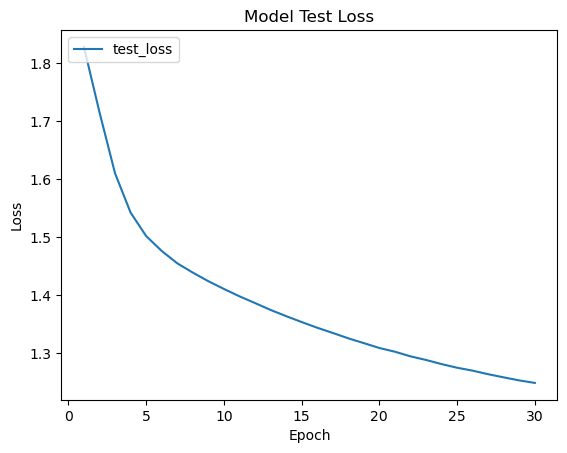

In [35]:
plot_graph(train_eva_df,'Model Train Loss','Epoch','Loss',['loss'],['train_loss'])
plot_graph(test_eva_df,'Model Test Loss','Epoch','Loss',['loss'],['test_loss'])

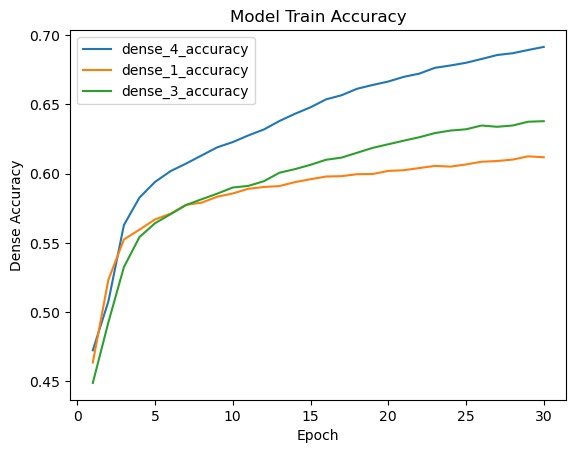

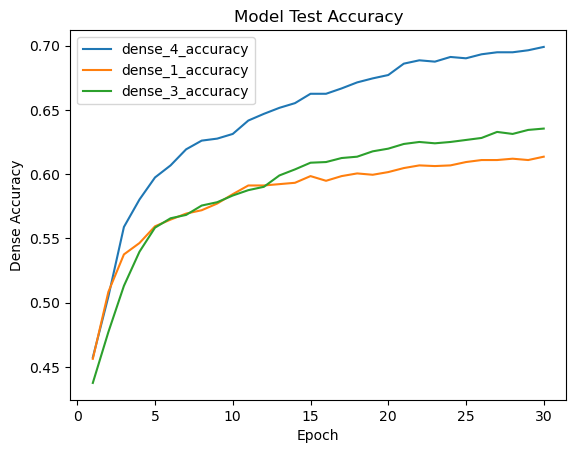

In [36]:
plot_graph(train_eva_df,'Model Train Accuracy','Epoch','Dense Accuracy',['dense_4_accuracy', 'dense_1_accuracy', 'dense_3_accuracy'])
plot_graph(test_eva_df,'Model Test Accuracy','Epoch','Dense Accuracy',['dense_4_accuracy', 'dense_1_accuracy', 'dense_3_accuracy'])

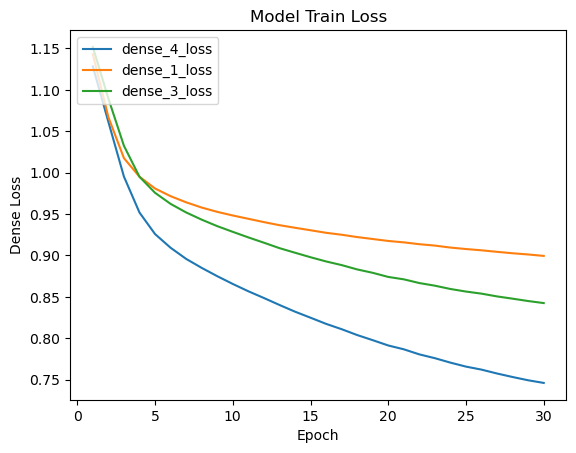

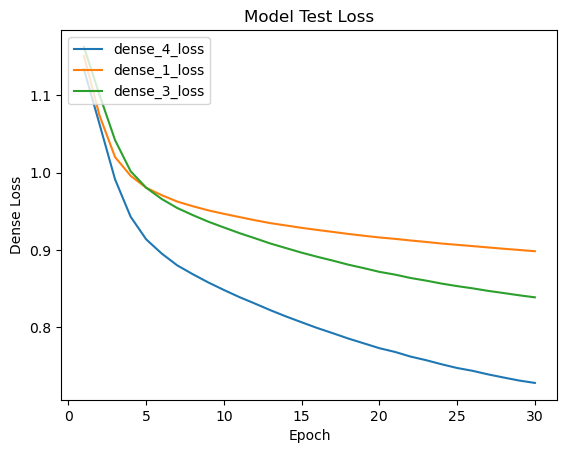

In [37]:
plot_graph(train_eva_df,'Model Train Loss','Epoch','Dense Loss',['dense_4_loss', 'dense_1_loss', 'dense_3_loss'])
plot_graph(test_eva_df,'Model Test Loss','Epoch','Dense Loss',['dense_4_loss', 'dense_1_loss', 'dense_3_loss'])

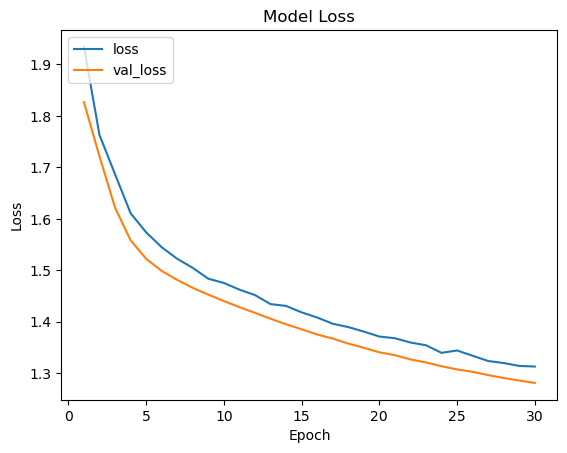

In [38]:
plot_graph(history_dataframe,'Model Loss','Epoch','Loss',['loss','val_loss'])

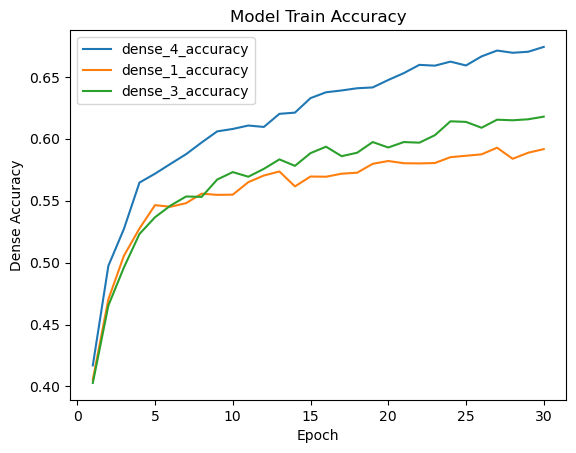

In [39]:
plot_graph(history_dataframe,'Model Train Accuracy','Epoch','Dense Accuracy',['dense_4_accuracy', 'dense_1_accuracy', 'dense_3_accuracy'])

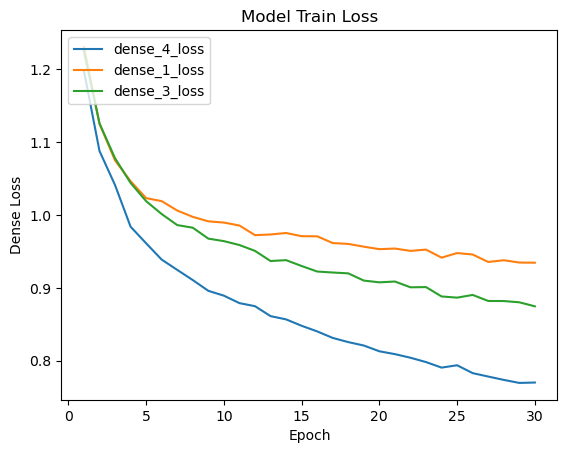

In [40]:
plot_graph(history_dataframe,'Model Train Loss','Epoch','Dense Loss',['dense_4_loss', 'dense_1_loss', 'dense_3_loss'])

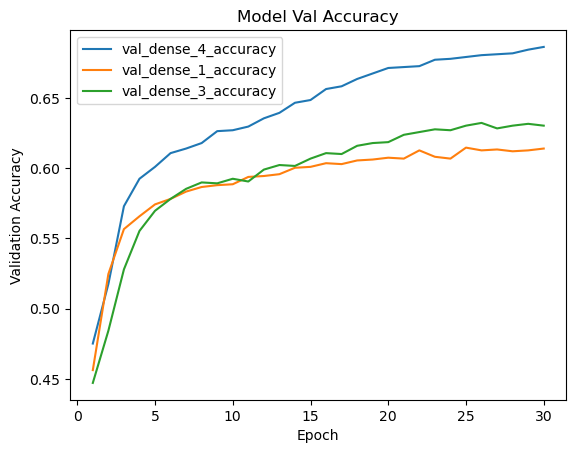

In [41]:
plot_graph(history_dataframe,'Model Val Accuracy','Epoch','Validation Accuracy',['val_dense_4_accuracy', 'val_dense_1_accuracy', 'val_dense_3_accuracy'])

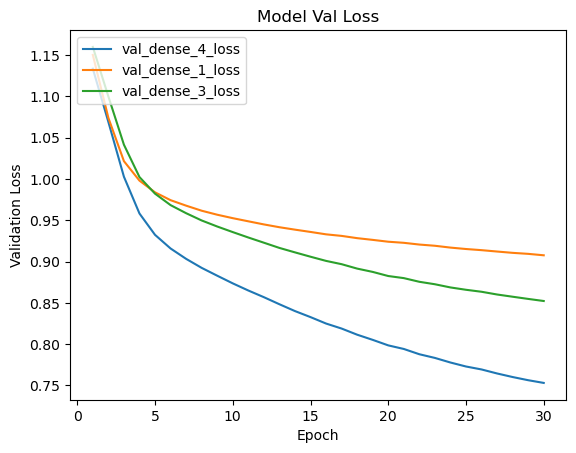

In [42]:
plot_graph(history_dataframe,'Model Val Loss','Epoch','Validation Loss',['val_dense_4_loss', 'val_dense_1_loss', 'val_dense_3_loss'])

In [43]:
VARIETIES

['HD 3086', 'PBW 291', 'DBW 187', 'DBW222']

In [44]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = model.predict(test_dataset)

60/60 [==============================] - 57s 934ms/step


In [45]:
y_pred_labels = np.argmax(y_pred, axis=2)

In [46]:
for y_pred_label in y_pred_labels:
    # Calculate accuracy
    accuracy = accuracy_score(test_dataset_label, y_pred_label)
    print("Accuracy:", accuracy)
    
    # Calculate confusion matrix
    cm = confusion_matrix(test_dataset_label, y_pred_label)
    print("Confusion Matrix:")
    print(cm)
    
    # Calculate precision, recall, and F1-score for each class
    print("Classification Report:")
    print(classification_report(test_dataset_label, y_pred_label))

Accuracy: 0.6989583333333333
Confusion Matrix:
[[321  36  26  97]
 [ 20 382  35  43]
 [ 22  47 398  13]
 [147  67  25 241]]
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.67      0.65       480
           1       0.72      0.80      0.75       480
           2       0.82      0.83      0.83       480
           3       0.61      0.50      0.55       480

    accuracy                           0.70      1920
   macro avg       0.70      0.70      0.70      1920
weighted avg       0.70      0.70      0.70      1920

Accuracy: 0.6135416666666667
Confusion Matrix:
[[315  38  39  88]
 [ 33 293  78  76]
 [ 25  60 374  21]
 [174  85  25 196]]
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.66      0.61       480
           1       0.62      0.61      0.61       480
           2       0.72      0.78      0.75       480
           3       0.51      0.41      0.46       480


In [47]:
tic = start_timer()
for x in range(30,35):
    print("\nEpoch: ",x+1)
    history = model.fit(x_train ,y_train ,batch_size=BATCH_SIZE ,epochs=1, verbose=2, validation_data=(x_val, y_val), shuffle=True)
    if history_dataframe.size == 0:
        history_dataframe = pd.DataFrame.from_dict(history.history)
    else:
        history_dataframe = pd.concat([history_dataframe,pd.DataFrame.from_dict(history.history)],axis=0,ignore_index=True)
    print("for testing")
    test_eva.append(model.evaluate(test_dataset,test_dataset_label))
    print("for training")
    train_eva.append(model.evaluate(train_dataset,train_dataset_label))
toc = end_timer()
show_time(tic,toc)

Testing started

Epoch:  31
768/768 - 2054s - loss: 1.3092 - dense_4_loss: 0.7665 - dense_1_loss: 0.9320 - dense_3_loss: 0.8767 - dense_4_accuracy: 0.6727 - dense_1_accuracy: 0.5946 - dense_3_accuracy: 0.6169 - val_loss: 1.2764 - val_dense_4_loss: 0.7494 - val_dense_1_loss: 0.9066 - val_dense_3_loss: 0.8502 - val_dense_4_accuracy: 0.6875 - val_dense_1_accuracy: 0.6146 - val_dense_3_accuracy: 0.6354 - 2054s/epoch - 3s/step
for testing
60/60 [==============================] - 57s 947ms/step - loss: 1.2442 - dense_4_loss: 0.7242 - dense_1_loss: 0.8970 - dense_3_loss: 0.8363 - dense_4_accuracy: 0.7005 - dense_1_accuracy: 0.6156 - dense_3_accuracy: 0.6385
for training
240/240 [==============================] - 226s 942ms/step - loss: 1.2638 - dense_4_loss: 0.7423 - dense_1_loss: 0.8982 - dense_3_loss: 0.8402 - dense_4_accuracy: 0.6930 - dense_1_accuracy: 0.6143 - dense_3_accuracy: 0.6409

Epoch:  32
768/768 - 2051s - loss: 1.3066 - dense_4_loss: 0.7655 - dense_1_loss: 0.9373 - dense_3_loss:

In [48]:
history_dataframe

,loss,dense_4_loss,dense_1_loss,dense_3_loss,dense_4_accuracy,dense_1_accuracy,dense_3_accuracy,val_loss,val_dense_4_loss,val_dense_1_loss,val_dense_3_loss,val_dense_4_accuracy,val_dense_1_accuracy,val_dense_3_accuracy
0,1.934029,1.197561,1.230397,1.224497,0.416992,0.405436,0.402832,1.826698,1.133629,1.150272,1.159960,0.475260,0.456380,0.447266
1,1.762791,1.087653,1.124948,1.125514,0.497396,0.470378,0.465332,1.721331,1.069121,1.074065,1.099967,0.517578,0.524740,0.484375
2,1.686661,1.040925,1.074726,1.077724,0.527181,0.505534,0.496094,1.621744,1.002783,1.021639,1.041565,0.572917,0.556641,0.527995
3,1.610867,0.983836,1.046256,1.043845,0.564616,0.527507,0.523112,1.558356,0.958231,0.998042,1.002375,0.592448,0.565755,0.555339
4,1.573644,0.961075,1.023033,1.018863,0.571777,0.546387,0.536621,1.522252,0.932405,0.983884,0.982270,0.600911,0.574219,0.569661
5,1.544762,0.938726,1.018922,1.001199,0.579753,0.545085,0.546061,1.498711,0.915878,0.974383,0.968394,0.610677,0.578125,0.578125
6,1.522237,0.924620,1.005990,0.986069,0.587565,0.548014,0.553385,1.481224,0.903319,0.967743,0.958608,0.613932,0.583333,0.585286
7,1.504592,0.910656,0.997338,0.982452,0.597005,0.555664,0.553060,1.465826,0.892400,0.961611,0.949807,0.617839,0.586589,0.589844
8,1.483513,0.895906,0.991202,0.967489,0.605957,0.554688,0.567057,1.452692,0.882917,0.956763,0.942490,0.626302,0.587891,0.589193
9,1.475333,0.889256,0.989531,0.964056,0.607910,0.554850,0.573079,1.440133,0.873634,0.952595,0.935732,0.626953,0.588542,0.592448


In [49]:
train_eva_df = pd.DataFrame(train_eva,columns=['loss','dense_4_loss','dense_1_loss','dense_3_loss','dense_4_accuracy','dense_1_accuracy','dense_3_accuracy'])
test_eva_df = pd.DataFrame(test_eva,columns=['loss','dense_4_loss','dense_1_loss','dense_3_loss','dense_4_accuracy','dense_1_accuracy','dense_3_accuracy'])

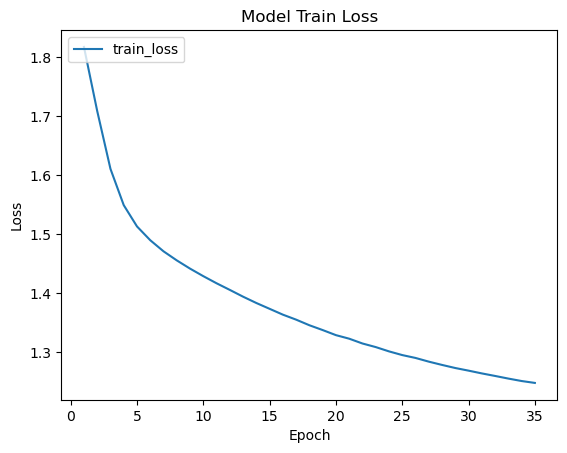

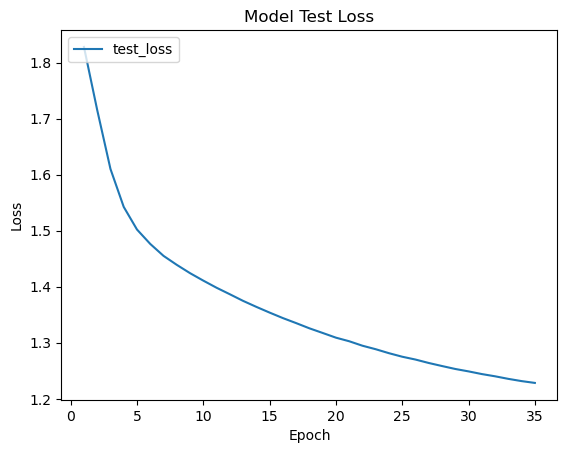

In [50]:
plot_graph(train_eva_df,'Model Train Loss','Epoch','Loss',['loss'],['train_loss'])
plot_graph(test_eva_df,'Model Test Loss','Epoch','Loss',['loss'],['test_loss'])

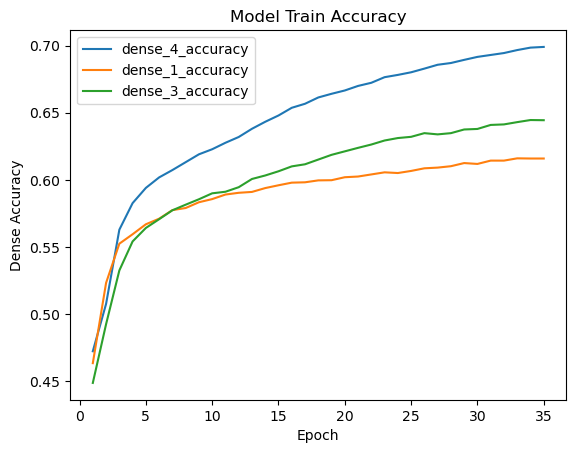

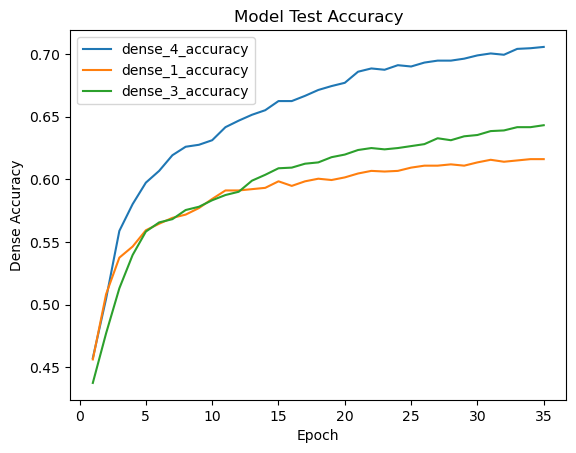

In [51]:
plot_graph(train_eva_df,'Model Train Accuracy','Epoch','Dense Accuracy',['dense_4_accuracy', 'dense_1_accuracy', 'dense_3_accuracy'])
plot_graph(test_eva_df,'Model Test Accuracy','Epoch','Dense Accuracy',['dense_4_accuracy', 'dense_1_accuracy', 'dense_3_accuracy'])

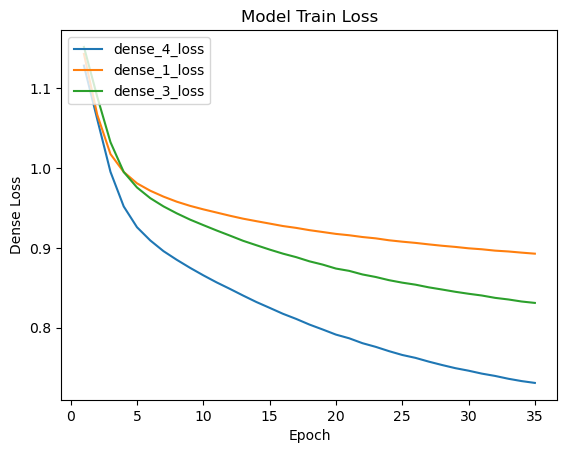

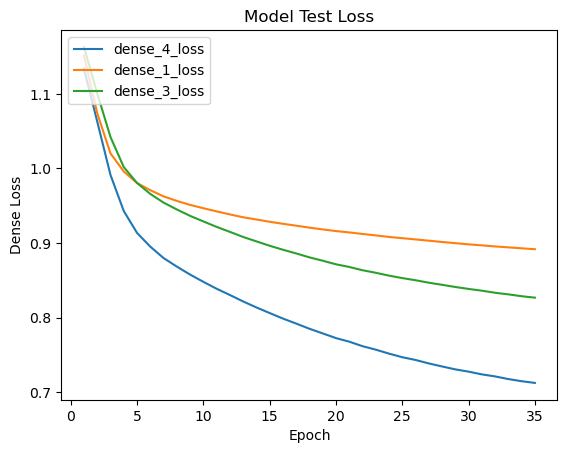

In [52]:
plot_graph(train_eva_df,'Model Train Loss','Epoch','Dense Loss',['dense_4_loss', 'dense_1_loss', 'dense_3_loss'])
plot_graph(test_eva_df,'Model Test Loss','Epoch','Dense Loss',['dense_4_loss', 'dense_1_loss', 'dense_3_loss'])

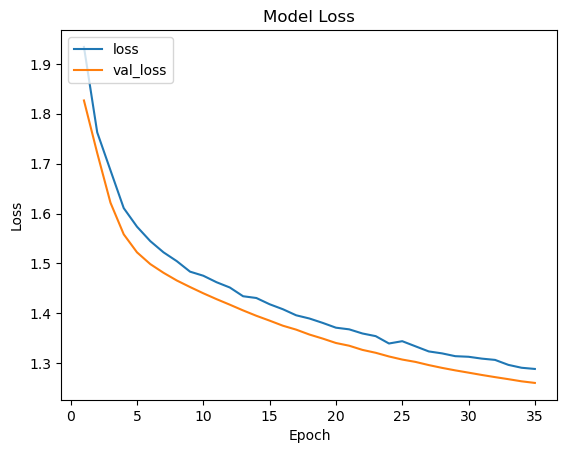

In [53]:
plot_graph(history_dataframe,'Model Loss','Epoch','Loss',['loss','val_loss'])

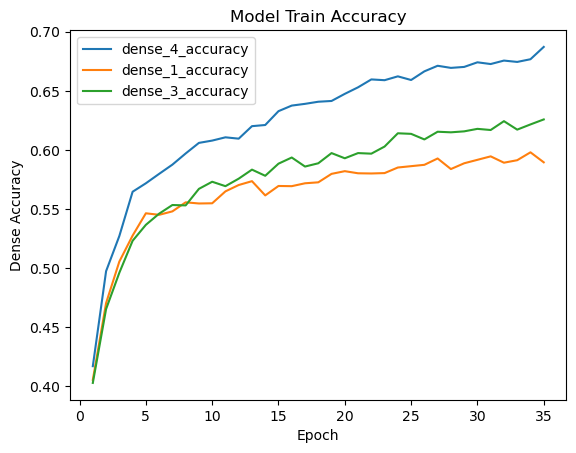

In [54]:
plot_graph(history_dataframe,'Model Train Accuracy','Epoch','Dense Accuracy',['dense_4_accuracy', 'dense_1_accuracy', 'dense_3_accuracy'])

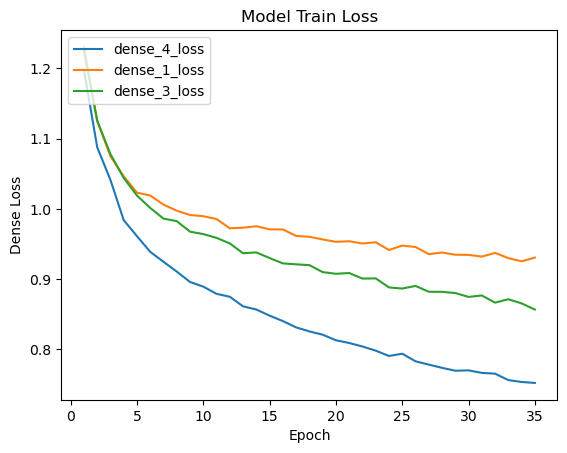

In [55]:
plot_graph(history_dataframe,'Model Train Loss','Epoch','Dense Loss',['dense_4_loss', 'dense_1_loss', 'dense_3_loss'])

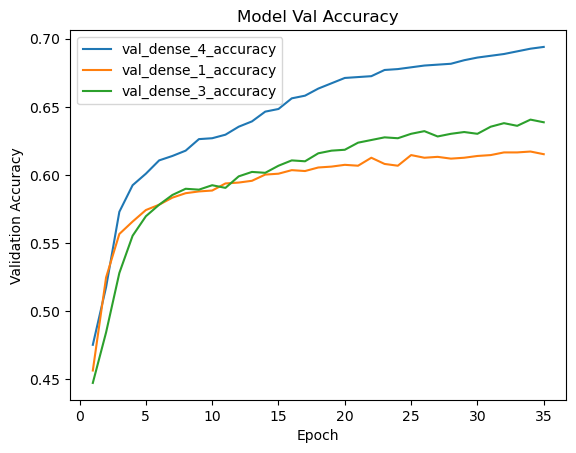

In [56]:
plot_graph(history_dataframe,'Model Val Accuracy','Epoch','Validation Accuracy',['val_dense_4_accuracy', 'val_dense_1_accuracy', 'val_dense_3_accuracy'])

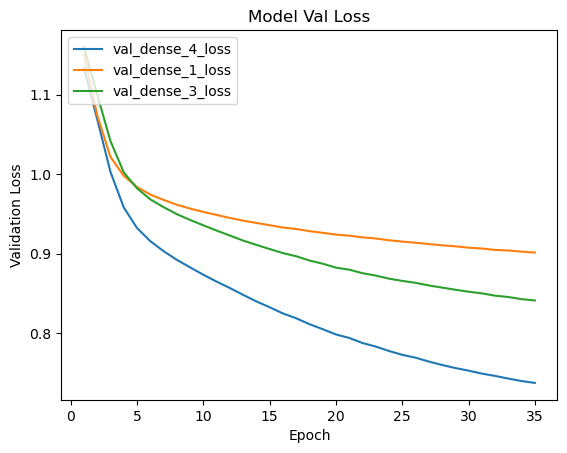

In [57]:
plot_graph(history_dataframe,'Model Val Loss','Epoch','Validation Loss',['val_dense_4_loss', 'val_dense_1_loss', 'val_dense_3_loss'])

In [58]:
VARIETIES

['HD 3086', 'PBW 291', 'DBW 187', 'DBW222']

In [59]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = model.predict(test_dataset)

60/60 [==============================] - 56s 936ms/step


In [60]:
y_pred_labels = np.argmax(y_pred, axis=2)

In [61]:
for y_pred_label in y_pred_labels:
    # Calculate accuracy
    accuracy = accuracy_score(test_dataset_label, y_pred_label)
    print("Accuracy:", accuracy)
    
    # Calculate confusion matrix
    cm = confusion_matrix(test_dataset_label, y_pred_label)
    print("Confusion Matrix:")
    print(cm)
    
    # Calculate precision, recall, and F1-score for each class
    print("Classification Report:")
    print(classification_report(test_dataset_label, y_pred_label))

Accuracy: 0.7057291666666666
Confusion Matrix:
[[327  33  34  86]
 [ 18 380  39  43]
 [ 22  42 404  12]
 [149  61  26 244]]
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.68      0.66       480
           1       0.74      0.79      0.76       480
           2       0.80      0.84      0.82       480
           3       0.63      0.51      0.56       480

    accuracy                           0.71      1920
   macro avg       0.70      0.71      0.70      1920
weighted avg       0.70      0.71      0.70      1920

Accuracy: 0.6161458333333333
Confusion Matrix:
[[316  38  39  87]
 [ 32 292  81  75]
 [ 24  56 380  20]
 [175  84  26 195]]
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.66      0.62       480
           1       0.62      0.61      0.61       480
           2       0.72      0.79      0.76       480
           3       0.52      0.41      0.46       480
